# Experiment and path specification

In [2]:
# Specify the experiment for analysis
experiment='xppl2816'
runNumber = 74

# Set the installation and output path
import os
os.environ['INSTALLPATH']='/reg/neh/home4/mrware/PhilTransA-TRXS-Limits'
os.environ['OUTPUTPATH']= '/reg/d/psdm/%s/%s/scratch' % (experiment[0:3],experiment)

# Import Libraries

In [3]:
# Magic iPython command to enable plotting
%matplotlib inline

# Load in the pythonBatchMagic library
import sys
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/pythonBatchMagic')
from pythonBatchMagic import *
# Determine current user
currentUser, error = unixCMD("echo $USER")
print(currentUser)
os.environ['RESULTSPATH']= ('/reg/d/psdm/%s/%s/res/%s' % (experiment[0:3],experiment,currentUser)).strip()
if not os.path.exists(os.environ['RESULTSPATH']):
    os.mkdir(os.environ['RESULTSPATH'])

mrware



OSError: [Errno 17] File exists: '/reg/d/psdm/xpp/xppl2816/res/mrware'

# Leveraging the batch queue to quickly grab point data

## Loading libraries

In [4]:
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/LCLS')
from LCLSdefault import *

sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/mattsTools')
from picklez import *

# Load in the get data library
from dataAnalysis import *

# Load in the batch library for lcls
from lclsBatch import *

/reg/d/psdm/xpp/xppl2816/scratch/Memories/getCSPADcoords remembered!


## Save/Load point data

In [5]:
# save_obj( pointData, os.environ['RESULTSPATH']+'/pointData-run-%d' % runNumber )
pointData = load_obj( os.environ['RESULTSPATH']+'/pointData-run-%d' % runNumber )

/reg/d/psdm/xpp/xppl2816/res/mrware/pointData-run-74 remembered!


## Plot histogram of result

In [ ]:
detArrays = pointData

fig2, ax2 = plt.subplots(1, 1)
ax2.hist(detArrays['ebeamcharge'], bins=100,normed=False, alpha=0.5);

# Read in CSPAD via batch job

## Specify good idxs

In [7]:
goodIdx = runFilter( pointData , filterOn=['opaint' , 'xint3','xpos3','ypos3', 'xint2','xpos2','ypos2', 'xrayEnergy','ebeamcharge','fltposfwhm','cspadSum','cspadMedian'], maddevs=3 ).astype(bool)


## Now generate time delays

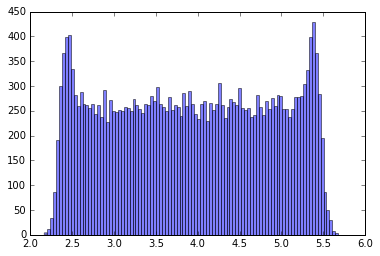

In [8]:
TTPoly = np.array([2.235e-7, -2.21e-3, 8.547e-1]) 

TTFltPos = pointData['ttfltpos']
TTCorrFltPos = TTPoly[0]*TTFltPos**2+TTPoly[1]*TTFltPos+TTPoly[2]

TTTime = TTCorrFltPos + pointData['stageencoder']

fig2, ax2 = plt.subplots(1, 1)
ax2.hist(TTTime[goodIdx], bins=100,normed=False, alpha=0.5);

# Read in timebinned CSPAD

In [ ]:

# timebins = np.arange( -1.5,1.5,.03 )
timebins = np.arange( 2.3,5.6,.03 ) # Run 74
dt = timebins[1]-timebins[0]
NT = timebins.size

tagList = []
for idx, t in enumerate(timebins):
    tIndex = (TTTime >= t-dt/2.)&(TTTime < t+dt/2.)
    allIndex = tIndex & goodIdx
    filteredSeconds = pointData['seconds'][allIndex]
    filteredNanoseconds = pointData['nanoseconds'][allIndex]
    filteredFiducials = pointData['fiducials'][allIndex]
    tagList.append( {'seconds':filteredSeconds, 'nanoseconds':filteredNanoseconds, 'fiducials':filteredFiducials} )

# batchThreads = batchCSPADGrabber (tagList, experiment=experiment, runNumber=runNumber)
batchThreads = batchCSPADMVGrabber (tagList, experiment=experiment, runNumber=runNumber)

batchThreads.Queue = 'psanaq'   
batchThreads.start()


In [ ]:
batchThreads.status
bjobs()

In [ ]:
batchThreads.requestStop()
bkill(killAll=True)

# Save / load resulting CSPAD

In [ ]:
batchThreads.gather()
CSPAD = batchThreads.CSPAD
variance = batchThreads.variance
counts = batchThreads.counts

In [6]:

# np.save(os.environ['RESULTSPATH']+'/timebins-run-%d' % runNumber ,timebins)
# np.save(os.environ['RESULTSPATH']+'/CSPAD-run-%d' % runNumber  , CSPAD)
# np.save(os.environ['RESULTSPATH']+'/variance-run-%d' %  runNumber , variance)
# np.save(os.environ['RESULTSPATH']+'/counts-run-%d' % runNumber  , counts)

timebins = np.load(os.environ['RESULTSPATH']+'/timebins-run-%d.npy' % runNumber )
CSPAD = np.load(os.environ['RESULTSPATH']+'/CSPAD-run-%d.npy' % runNumber)
variance = np.load(os.environ['RESULTSPATH']+'/variance-run-%d.npy' % runNumber)
counts = np.load(os.environ['RESULTSPATH']+'/counts-run-%d.npy' % runNumber)


# Plot CSPAD

58.2595789017


/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.3.9/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


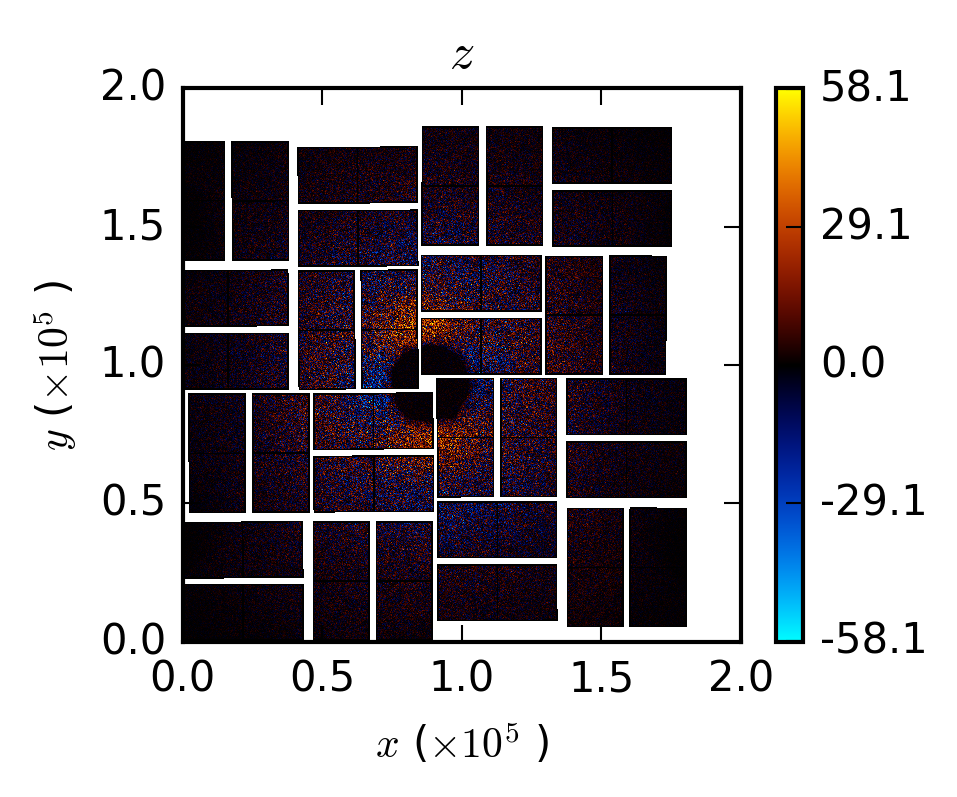

In [7]:
from IPython.display import clear_output
from plotStyles import *

def plotCSPAD( cspad , x , y, cspadMask=None, zLims = None, divergent=False ):
    figOpts = {'xLims':[0,2e5],'yLims':[0,2e5],'divergent':divergent, 'xIn':3, 'yIn':3*11.5/14.5}
    
    if cspadMask is not None:
        cspad=cspad*cspadMask
    
    if zLims is not None:
        figOpts['zLims'] = zLims
    
    for iTile in range(32):
        if iTile == 0:
            newFigure = True
        else:
            newFigure = False
        clear_output()
        colorPlot( x[iTile,:,:], y[iTile,:,:], cspad[iTile,:,:] , newFigure=newFigure, **figOpts);

x,y = CSPADgeometry()
cspadMask = createMask()

CSPADbinned = CSPAD
        
plotCSPAD( CSPADbinned[:,:,:,40]-CSPADbinned[:,:,:,30], x , y , cspadMask=cspadMask, divergent=True )